In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from keras.layers import Dense, LSTM, Dropout, Input
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam, Adamax, Nadam
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline

In [2]:
df = yf.download('AAPL', "2019-01-01", datetime.today().strftime('%Y-%m-%d')).reset_index()
df = df.drop(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Close
0,39.480000
1,35.547501
2,37.064999
3,36.982498
4,37.687500


In [3]:
df.shape

(1381, 1)

In [4]:
data_training = df['Close'][:int(len(df) * 0.70)]
data_testing = df['Close'][int(len(df) * 0.70):]

print(data_training.shape)
print(data_testing.shape)

(966,)
(415,)


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_training.values.reshape(-1, 1))

In [6]:
x_train = []
y_train = []

for i in range (100, len(scaled_data)):
    x_train.append(scaled_data[i-100:i])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_training], ignore_index=True)
final_df_scaled = scaler.fit_transform(final_df.values.reshape(-1, 1))

In [7]:
x_train.shape

(866, 100, 1)

In [8]:
y_train.shape

(866,)

In [9]:
final_df_scaled.shape

(1066, 1)

In [10]:
x_test = []
y_test = []

for i in range(100, len(final_df_scaled)):
    x_test.append(final_df_scaled[i-100:i])
    y_test.append(final_df_scaled[i,0])
    
x_test, y_test = np.array(x_test), np.array(y_test)



In [11]:
# Function to build the model
model = Sequential()
model.add(Input(shape=(100,1)))
model.add(LSTM(units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100, activation='relu', return_sequences=True))  # Ensure this layer also returns sequences
model.add(Dropout(0.4))
model.add(LSTM(units=100, activation='relu'))  # The last LSTM layer should not return sequences
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='linear'))

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,101 (1.08 MB)

 Trainable params: 282,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

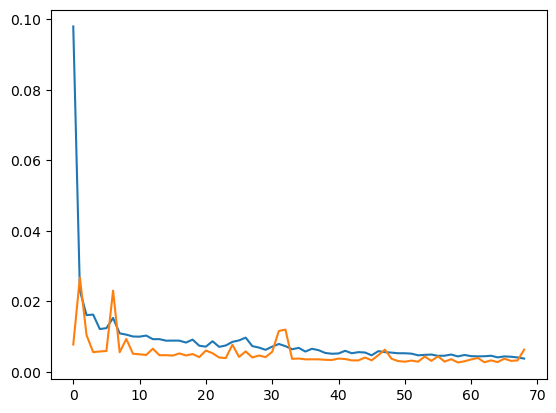

In [14]:
import tensorflow as tf 
model.compile(optimizer='Adam', loss='mse', metrics=['mse'])
# Train the final model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
final_history = model.fit(x_train, y_train, epochs=70, batch_size=32, validation_split=0.2,
                                callbacks=[early_stopping], verbose=0)

plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])

In [18]:
# Evaluate the final model
y_pred = model.predict(x_test)
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate final R2 score
final_r2 = r2_score(y_test_inverse, y_pred_inverse)
print(final_r2*100)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
94.00061819493379


In [22]:
model.save('my_model.keras')